In [1]:
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
%matplotlib inline 


D = 2


TRUE_MU = 0.0
TRUE_SIGMA = 2.0
SAMPLE_SIZE = (5000,D)

np.random.seed(0)
x_obs = np.random.normal(loc=TRUE_MU, scale=TRUE_SIGMA, size=SAMPLE_SIZE)
rsq = np.square(x_obs).sum(axis=-1)

keep = rsq > np.mean(rsq)
x_obs = x_obs[keep]

#### Random Linear transformation
# C = pyutil.random_covmat()
# x_obs = x_obs.dot(C)

#### Make an ellipse
x_obs.T[0] *= 0.5

# x_obs = np.square(x_obs)
pyvis.qc_2var(x_obs.T[0],x_obs.T[1])

In [2]:

import numpy as np
import pymisca.util as pyutil;reload(pyutil)
import pymisca.vis_util as pyvis;reload(pyvis)
import pymisca.tensorflow_extra as pytf;reload(pytf)
import tensorflow_probability as tfp
import tensorflow as tf
tfdist = tfp.distributions

%matplotlib inline 

is in ipython: 1
is in ipython: 1
is in ipython: 1
[WARN] pymisca.vis_util cannot find network
[WARN] pymisca.vis_util cannot find network


/home/shouldsee/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[WARN]unable to import edward.models
[WARN]unable to import edward.models


\int P(	heta) P(r^2) \partial x \partial y
0.9564518332481384


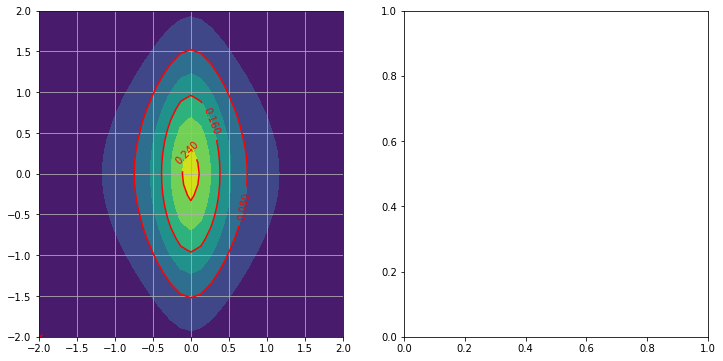

In [3]:

def makeEMD( (mu,phi,sigma) ):
    dist_rsq   = tfdist.Gamma(mu,phi)
#     dist_rsq = tfbij.Invert(tfbij.Square()) (dist_r)
    dist_rsqTheta = mdl=  pytf.JointScalar(
        [
            tfdist.Cauchy(loc= 0.,scale= 0.5,name='x'),
            tfdist.Normal(0., 1.,),
        ])

    return mdl

em = makeEMD((1.,1.,2.))
sess = tf.InteractiveSession()
f = em.prob
f = pyutil.wrapTFmethod(f)
f = pyutil.arrayFunc2mgridFunc(f)

with sess.as_default():
    pyvis.dmet_2d(f,vectorised=1);
    pyutil.printlines(
        ('\int P(\theta) P(r^2) \partial x \partial y',
           pyutil.cubicRInt(f.arrayFunc,D=D,N=2000000,R=16.))
    )    
    pass
        


/home/shouldsee/.local/lib/python2.7/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


\int P(	heta) P(r^2) \partial x \partial y
0.9914507269859314
\int P(	heta) \partial 	heta
1.9828015341535832


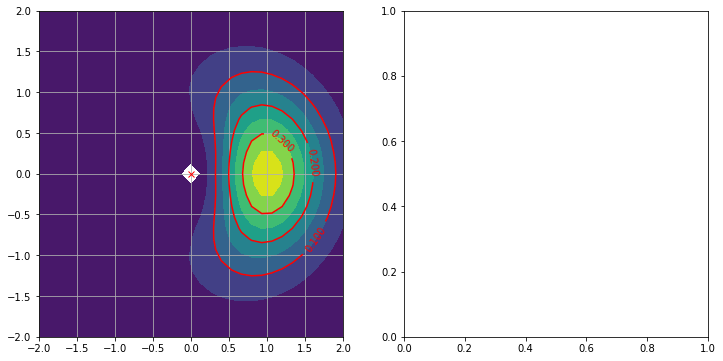

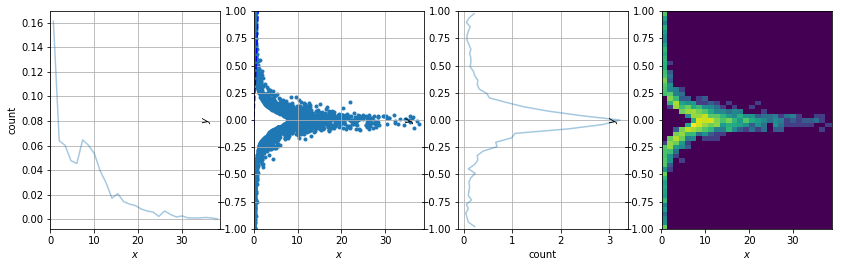

In [18]:
tloc = 0.
def makeEMD( (mu,phi,sigma) ):
    dist_rsq   = tfdist.Gamma(mu,phi)
#     dist_rsq = tfbij.Invert(tfbij.Square()) (dist_r)

    
    dist_Theta = pytf.VonMisesFisherCosine(D=2,concentration = sigma)

    dist_rsqTheta = mdl=  pytf.JointScalar(
        [
            tfdist.Gamma(mu,phi,name='r_squared'),
            dist_Theta,
        ])

    #### Use a bijector to calculate P(x) from P(r^2)
    dist_xyz = mdl = pytf.AsRadialCosine(distribution=mdl,D=D)
    
    ### Allow an affine transformation y = M x + x_0
#     dist_aff = mdl = pytf.AffineTransformDiag(distribution=dist_xyz,
#                                         scale_diag=sigma,)
    # gaussian_dist = tf.contrib.distributions.Normal(loc=mu, scale=sigma)
    # emission  = dist_rsq
    return mdl
# print em.distribution.event_shape
em = makeEMD((2., 1.,2.))
sess = tf.InteractiveSession()
f = em.prob
f = pyutil.wrapTFmethod(f)
f = pyutil.arrayFunc2mgridFunc(f)

with sess.as_default():
    pyvis.dmet_2d(f,vectorised=1);
    iY = em.bijector.inverse(X).eval()
    pyvis.qc_2var(iY.T[0],iY.T[1])
    pyutil.printlines(
        ('\int P(\theta) P(r^2) \partial x \partial y',
           pyutil.cubicRInt(f.arrayFunc,D=D,N=2000000,R=16.))
    )

    import scipy.stats as spstats
    f = spstats.norm._pdf
    pyutil.printlines(('\int P(\theta) \partial \theta',
    pyutil.surfInt(lambda x:f(x-tloc))))



In [19]:
RANDOM_SEED = 3
np.random.seed(RANDOM_SEED)
INIT_MU_PARAMS = {'loc':0.,'scale':1.}
mu = 0. + tf.nn.softplus(tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                 dtype=tf.float32)
                )
phi =tf.nn.softplus( tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                  dtype=tf.float32)
                )
sigma =tf.nn.softplus( tf.Variable(initial_value=np.random.normal(**INIT_MU_PARAMS),
                  dtype=tf.float32)
                )
x = tf.placeholder(dtype='float32')
fitted_vars = [mu,phi,sigma]


EMD = makeEMD(fitted_vars)
neg_log_likelihood = -tf.reduce_sum(EMD.log_prob(x))
# neg_log_likelihood = 
#### Adapted from: http://kyleclo.github.io/maximum-likelihood-in-tensorflow-pt-1/
reload(pytf)
LEARNING_RATE = 0.1
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
sess,last_vars, hist_loss, opt = pytf.op_minimise(
    neg_log_likelihood,
    fitted_vars,
    optimizer,
    feed_dict = {x: x_obs}
)

[WARN]unable to import edward.models
Iter 0 12790.85
Iter 100 7821.03
Iter 200 7819.7744
Iter 300 7819.383
Loss function convergence in 354 iterations!: 7819.26855469


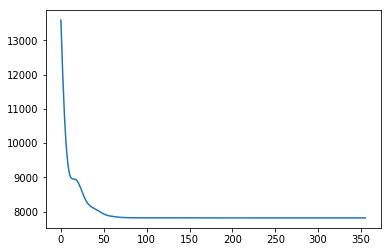

In [20]:
import pymisca.vis_util as pyvis
%matplotlib inline 

plt = pyvis.plt
plt.plot(hist_loss)

In [ ]:
print (last_vars)

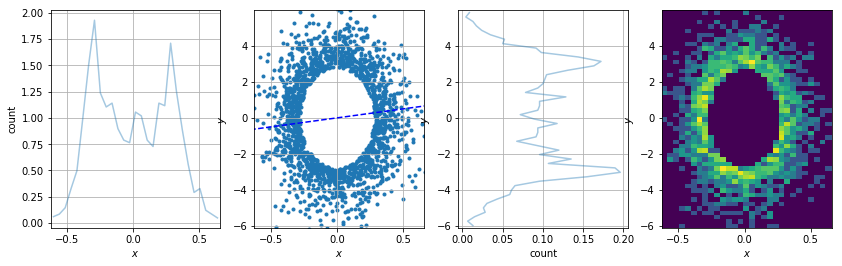

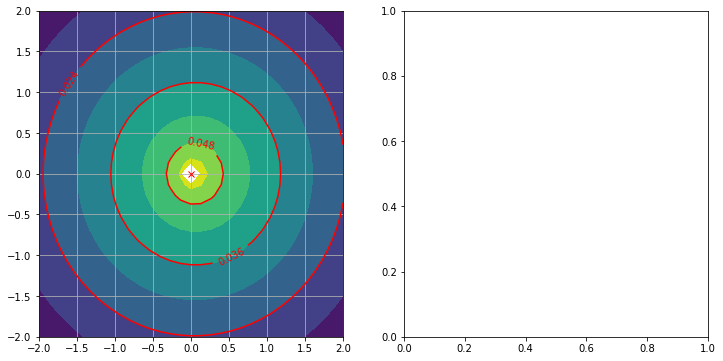

In [22]:
with sess.as_default():
# sess = tf.InteractiveSession()
# if 1:
    EMD = makeEMD(last_vars)
    X = x_obs
    pyvis.qc_2var(X.T[0],X.T[1])
    
    f = EMD.prob
    f = pyutil.wrapTFmethod(f)
    f = pyutil.arrayFunc2mgridFunc(f)
    pyvis.dmet_2d(f,vectorised=1);    
#     Y = EMD.sample(len(X)).eval()

#     pyvis.qc_2var(Y.T[0],Y.T[1])

In [ ]:
X = np.random.random((500,100,2))
EMD.log_prob(X.astype(np.float32))